In [5]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from smr import File
import numpy as np
from matplotlib import pyplot as plt


In [6]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K10/error_direction/K10_1_directionaltest.smr'

In [9]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 5)


<IPython.core.display.Javascript object>


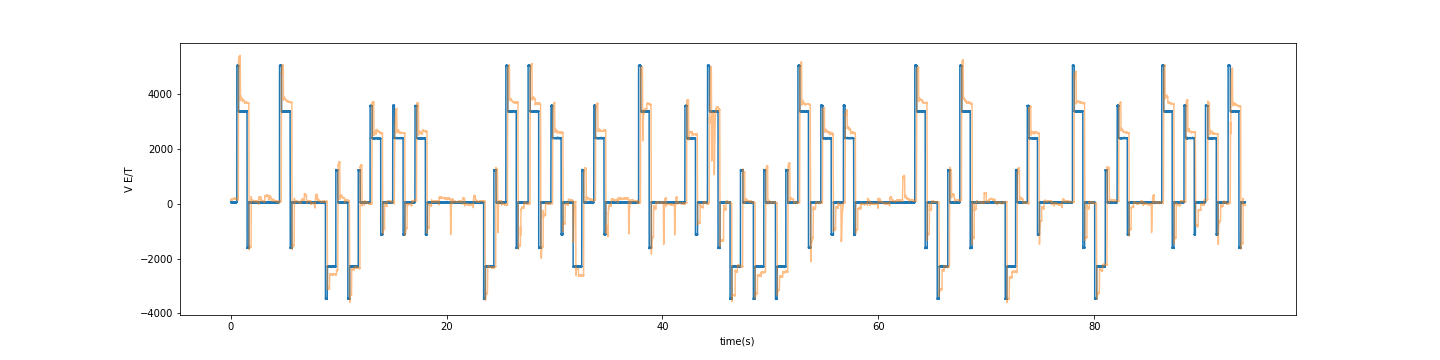

<IPython.core.display.Javascript object>


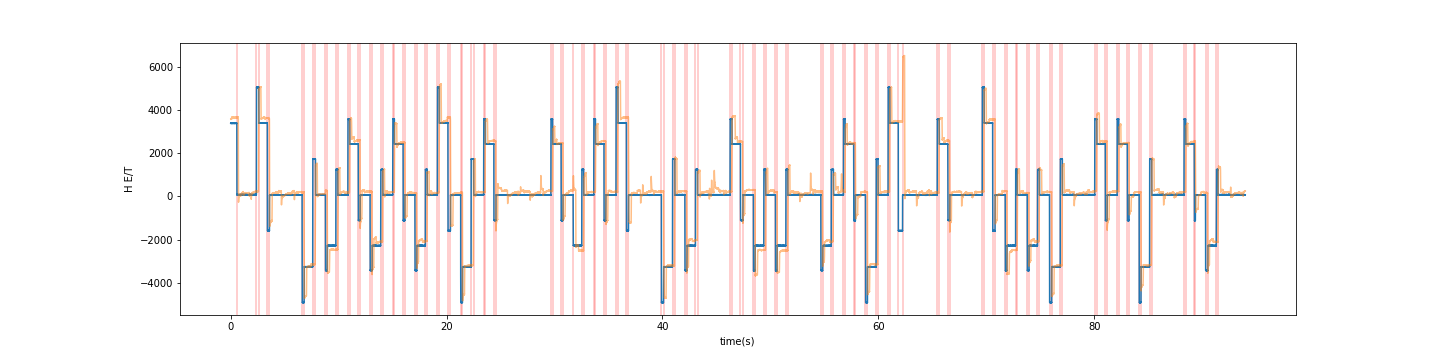

In [20]:
%matplotlib notebook
import scipy.signal

# import time
#time.sleep(5)  

#Params:
t_range = (6,100) #s
fsize = (20,5)


vt = smr_content.get_channel(4)
ve = smr_content.get_channel(2)


i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange])
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange], alpha=0.5)
plt.ylabel(vt.title)
plt.xlabel('time(s)')

ht = smr_content.get_channel(3)
he = smr_content.get_channel(1)

plt.figure(figsize = fsize)
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange])
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange], alpha=0.5)
plt.ylabel(ht.title)
plt.xlabel('time(s)')


ht_diff = np.abs(np.diff(ht.data[prange]))
target_jump_indices = scipy.signal.find_peaks(ht_diff, prominence=100)[0]
# plt.plot(peaks*ht.dt, ht.data[prange][peaks], '*r')

from kaveh import plots
plots.axvlines(plt.gca(), target_jump_indices*ht.dt, alpha = 0.25, color='red')

# plt.figure()
# for i in range(1000):
#     plt.plot(ht.data[prange],vt.data[prange], '.')
#     plt.xlabel(ht.title[i])
#     plt.ylabel(vt.title[i])
#     time.sleep(0.01)
#     plt.cla()

<IPython.core.display.Javascript object>


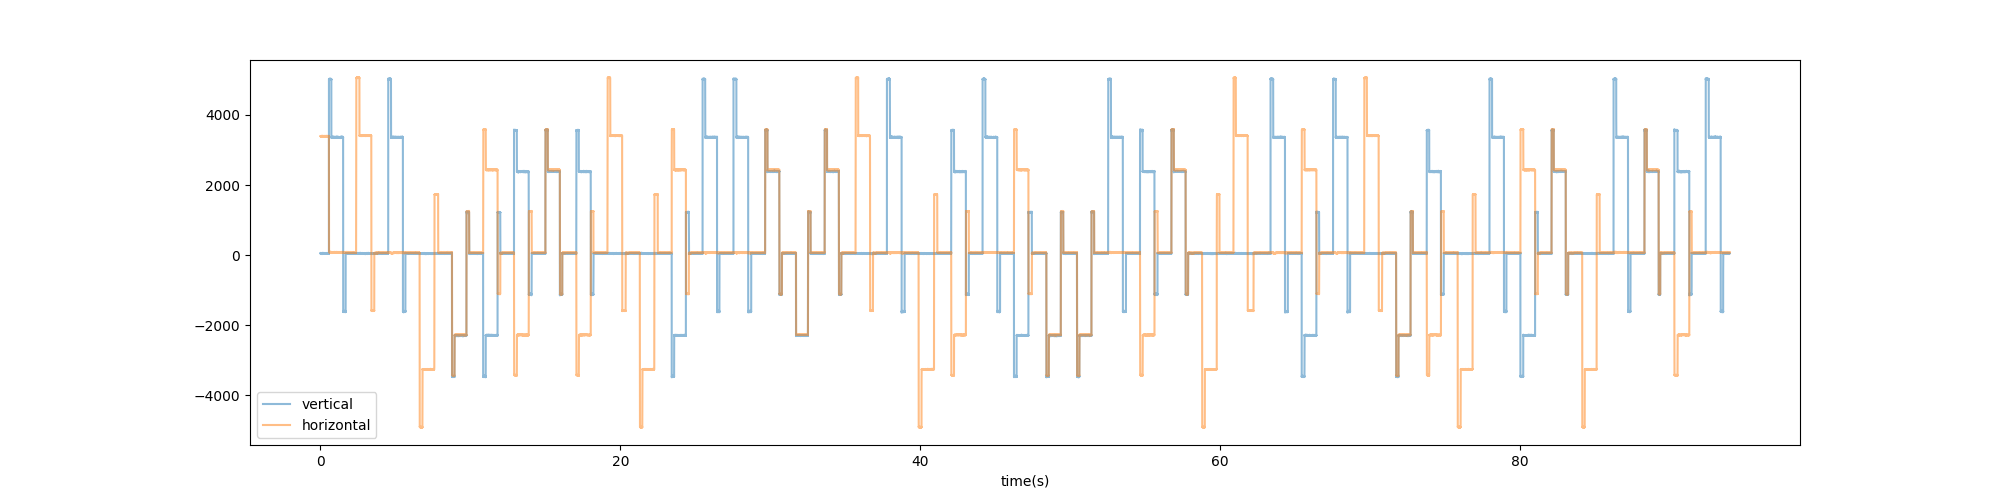

In [11]:
t_range = (6,100) #s
fsize = (20,5)


vt = smr_content.get_channel(4)

i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange], alpha=0.5)
plt.xlabel('time(s)')
ht = smr_content.get_channel(3)
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange] , alpha=0.5)
plt.legend(['vertical', 'horizontal'])


KeyboardInterrupt: 

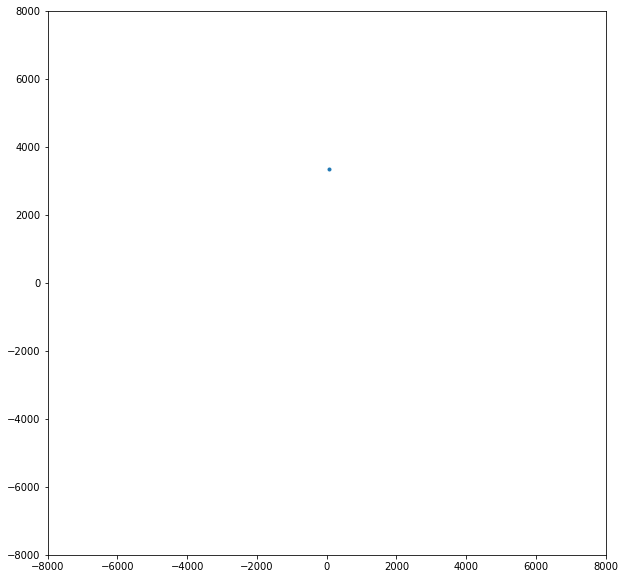

In [15]:
%matplotlib inline
import time
# import pylab as pl
from IPython import display
plt.figure(figsize=(10,10))

for i in range(i_range[0], i_range[1], 5):
    plt.plot(ht.data[i],vt.data[i], '.')
    plt.ylim((-8000,8000))
    plt.xlim((-8000,8000))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.005)
    plt.cla()
#     plt.cla()

In [ ]:
plt.figure(figsize=fsize)
ht_diff = np.abs(np.diff(ht.data[prange]))
plt.plot(np.arange(0, ht_diff.size)*ht.dt, ht_diff)
plt.ylabel("diff of {}".format(ht.title))
plt.xlabel('time(s)')

import scipy.signal

peaks = scipy.signal.find_peaks(ht_diff, prominence=100)[0]-1

plt.plot(peaks*ht.dt, ht_diff[peaks], '*r')
# plt.figure(figsize=fsize)
# plt.plot(scipy.signal.find_peaks(ht_diff)[1])

In [ ]:
# import csv
# import os

# def append_to_csv_string(csv_string, new_string):
#     if not csv_string:
#         return new_string
#     else:
#         return [csv_string] + [new_string]


# source_path = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/'

# with open('behavioral_index.csv', 'a') as f:
#     for root, dirnames, filenames in os.walk(source_path):
#         for filename in filenames:
#             if filename.endswith('smr'):
#                 f_name = os.path.join(root, filename)
#                 csv_row = [f_name];
                
#                 smr_content = File(f_name)
#                 smr_content.read_channels()
                
#                 chans = smr_content.channels
                
#                 for i, chan in enumerate(chans):
#                     if 'VT' in chan.title:
#                         csv_row = csv_row + ['VT'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['VT'] + ['NA']

#                     if 'HT' in chan.title:
#                         csv_row = csv_row + ['HT'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['HT'] + ['NA']

#                     if 'VE' in chan.title:
#                         csv_row = csv_row + ['VE'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['VE'] + ['NA']

#                     if 'HE' in chan.title:
#                         csv_row = csv_row + ['HE'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['HE'] + ['NA']

#                 print(csv_row)
#                 writer = csv.writer(f)
#                 writer.writerow(csv_row)

                        
                    
                    
            